# **FACE RECOGNITION WITH CNN**

At the first, you should input the required libraries:

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

import numpy as np
import pandas as pd

## Load Dataset

Sau khi tiền xử lý hình ảnh từ tập train, ta sẽ đọc dữ liệu đó từ file `train.csv` và lưu vào biến `data`.

In [16]:
#load dataset
data = pd.read_csv('./train.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12535,12536,12537,12538,12539,12540,12541,12542,12543,12544
0,0.036693,0.096633,0.072820,0.092711,0.090762,0.052379,0.004487,0.004487,0.004204,0.003922,...,0.033054,0.009807,0.021855,0.033902,0.058280,0.091051,0.091357,0.094445,0.086602,0.0
1,0.025479,0.025479,0.029400,0.033322,0.017636,0.021557,0.029400,0.029400,0.021557,0.017636,...,0.120355,0.121188,0.109423,0.113345,0.101580,0.099631,0.102719,0.098797,0.090121,0.0
2,0.359521,0.313296,0.256704,0.236240,0.248288,0.249687,0.230079,0.175177,0.143804,0.117737,...,0.112692,0.111858,0.114091,0.114924,0.096432,0.068981,0.061971,0.081296,0.107058,0.0
3,0.318180,0.291883,0.281004,0.258628,0.146905,0.165144,0.235181,0.187855,0.163775,0.162941,...,0.051761,0.092926,0.101320,0.108330,0.111135,0.076124,0.070818,0.073624,0.073907,0.0
4,0.024095,0.024928,0.028016,0.023262,0.023544,0.027183,0.023812,0.019608,0.015686,0.009793,...,0.545609,0.549531,0.549531,0.549531,0.555424,0.551503,0.539738,0.519580,0.506431,0.0


Tiếp theo, ta sẽ tách nhãn (`Y`) và giá trị thuộc tính của hình ảnh (`X`). 

In [17]:
X = np.array(data.iloc[:, :-1])
Y = np.array(data.iloc[:, -1])

Khởi tạo giá trị kích thước của hình ảnh

In [18]:
im_rows = 112
im_cols = 112
im_shape = (im_rows, im_cols, 1)
count_out = len(np.unique(Y))

## Xây dựng mô hình CNN

Mô hình CNN này sẽ có 3 lớp: 
1. Lớp Convolotional  
2. Lớp Pooling   
3. Lớp Fully connected 
 
Chúng ta có thể tạo ra một mạng CNN mới nếu thay đổi thứ tự của các lớp.
 

In [19]:
#filters= the depth of output image or kernels

cnn_model= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape= im_shape),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    # count_out là số lượng output
    Dense(count_out, activation='softmax')  
])


cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

Show the model's parameters.

In [20]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 106, 106, 36)      1800      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 53, 53, 36)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 49, 49, 54)        48654     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 54)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 31104)             0         
                                                                 
 dense_8 (Dense)             (None, 2024)             

# Train the model

Ta sẽ thực hiện train model trên toàn bộ dữ liệu `data`, bằng cách sử dụng Cross-Validation, K-Fold với K = 5.

Tuỳ vào số lượng output (nghĩa là tuỳ vào số lượng hình ảnh tập train của mỗi người) mà ta nên thay đổi epochs cho phù hợp

In [21]:
from sklearn.model_selection import StratifiedKFold as kfold
x = X.reshape(X.shape[0], *im_shape)
y = Y

splits = 5
batch_size = 512
kf = kfold(splits, shuffle=True)
indices = kf.split(x, y)
loss_cnn_three_layer = []
acc_cnn_three_layer = []
preds = []
for train, valid in indices:
    x_train, x_valid, y_train, y_valid = x[train], x[valid], y[train], y[valid]
    
    # Thực hiện train model 
    history = cnn_model.fit(
        x_train, y_train, batch_size = batch_size,
        epochs = 60, verbose = 2,
        validation_data=(x_valid, y_valid),
    )
    
    prediction = cnn_model.predict(x_valid)
    loss_cnn_three_layer.append(history.history["loss"])
    acc_cnn_three_layer.append(history.history["accuracy"])
    preds.append(prediction)

Epoch 1/60
5/5 - 21s - loss: 2.9755 - accuracy: 0.0685 - val_loss: 2.8989 - val_accuracy: 0.0951 - 21s/epoch - 4s/step
Epoch 2/60
5/5 - 20s - loss: 2.9355 - accuracy: 0.0773 - val_loss: 2.8976 - val_accuracy: 0.0757 - 20s/epoch - 4s/step
Epoch 3/60
5/5 - 20s - loss: 2.9540 - accuracy: 0.0642 - val_loss: 2.9063 - val_accuracy: 0.0757 - 20s/epoch - 4s/step
Epoch 4/60
5/5 - 20s - loss: 2.9280 - accuracy: 0.0729 - val_loss: 2.9113 - val_accuracy: 0.0796 - 20s/epoch - 4s/step
Epoch 5/60
5/5 - 20s - loss: 2.9334 - accuracy: 0.0710 - val_loss: 2.9151 - val_accuracy: 0.0874 - 20s/epoch - 4s/step
Epoch 6/60
5/5 - 20s - loss: 2.9326 - accuracy: 0.0671 - val_loss: 2.9132 - val_accuracy: 0.1553 - 20s/epoch - 4s/step
Epoch 7/60
5/5 - 20s - loss: 2.9168 - accuracy: 0.0724 - val_loss: 2.8995 - val_accuracy: 0.0816 - 20s/epoch - 4s/step
Epoch 8/60
5/5 - 20s - loss: 2.9156 - accuracy: 0.0802 - val_loss: 2.8818 - val_accuracy: 0.0816 - 20s/epoch - 4s/step
Epoch 9/60
5/5 - 20s - loss: 2.9173 - accuracy: 

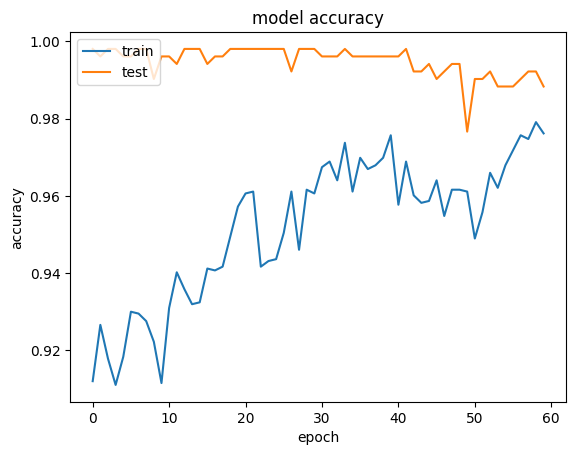

In [22]:
import matplotlib.pylab as plt

# list all data in history
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

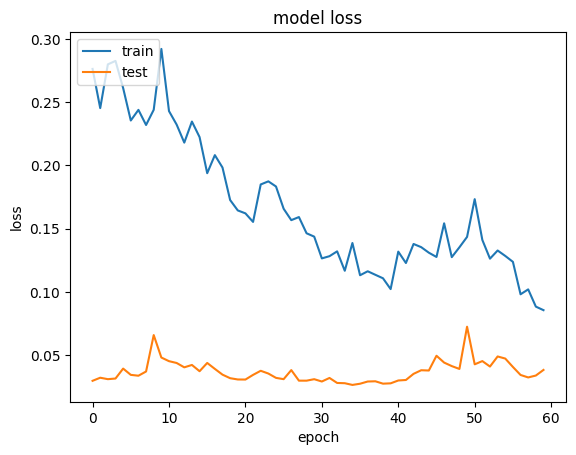

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Ghi mô hình ra file `models.h5`, để khi test thì ta chỉ cần đọc mô hình vào mà không cần phải train lại.

In [24]:
keras.models.save_model(cnn_model, filepath= 'models.h5')